In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pykalman import KalmanFilter
from statsmodels.nonparametric.smoothers_lowess import lowess
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%config InlineBackend.figure_format = 'svg'

def get_data(file):
    return pd.read_csv(file, parse_dates=[-1])


def plot_without_smoothing(cpu_data):
    plt.plot(cpu_data['timestamp'], cpu_data['temperature'], 'b.', alpha=0.5)
    

def plot_with_lowess_smoothing(cpu_data):
    input_range = cpu_data['timestamp']
    noisy_signal = cpu_data['temperature']
    lowess_smoothed = lowess(noisy_signal, input_range, frac=0.025)
    
    plt.plot(input_range, lowess_smoothed[:, 1], 'r-')
    
    
def plot_with_kalman_smoothing(cpu_data):
    kalman_data = cpu_data[['temperature', 'cpu_percent', 'sys_load_1']]
    
    
    # Kalman filter parameters
    initial_state = kalman_data.iloc[0]
    observation_covariance = np.diag([0.5, 0.5, 0.5]) ** 2
    transition_covariance = np.diag([0.2, 0.2, 0.2]) ** 2
    transition = [[1, -1, 0.7], [0, 0.6, 0.03], [0, 1.3, 0.8]]
    
    # create Kalman filter
    kf = KalmanFilter(
        initial_state_mean=initial_state,
        initial_state_covariance=observation_covariance,
        observation_covariance=observation_covariance,
        transition_covariance=transition_covariance,
        transition_matrices=transition
    )
    
    kalman_smoothed, _ = kf.smooth(kalman_data)
    plt.plot(cpu_data['timestamp'], kalman_smoothed[:, 0], 'g-')
    

def draw_plots(cpu_data):
    plt.figure(figsize=(12, 4))
    plt.xticks(rotation=25)
    plt.xlabel('Dates')
    plt.ylabel('Temperatures ($^\circ$C)')

    plot_without_smoothing(cpu_data)
    plot_with_lowess_smoothing(cpu_data)
    plot_with_kalman_smoothing(cpu_data)
    
    plt.legend(['Data points','LOESS-smoothed line', 'Kalman-smoothed line'])
    plt.show()

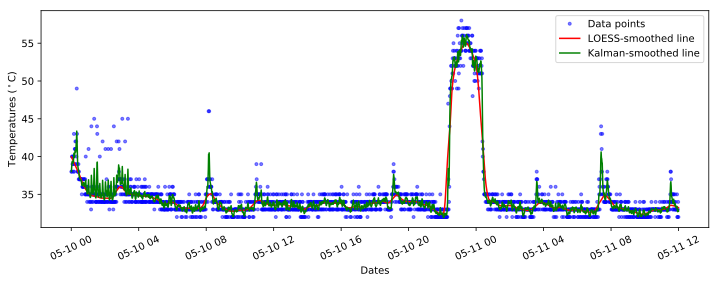

In [2]:
cpu_data = get_data('sysinfo.csv')
draw_plots(cpu_data)